Import Libraries

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
import joblib


**Load the Dataset**

In [ ]:

df = pd.read_csv('Churn_Modelling.csv')

print("Dataset Head:")
print(df.head())

print("\nMissing Values:")
print(df.isnull().sum())

print("\nDataset Description:")
print(df.describe())


Dataset Head:
   RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2       0.00              1          1               1   
1       1   83807.86              1          0               1   
2       8  159660.80              3          1               0   
3       1       0.00              2          0               0   
4       2  125510.82              1          1               1   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        113931.57       1  
3         93826.63       0  

**Data Visualization**

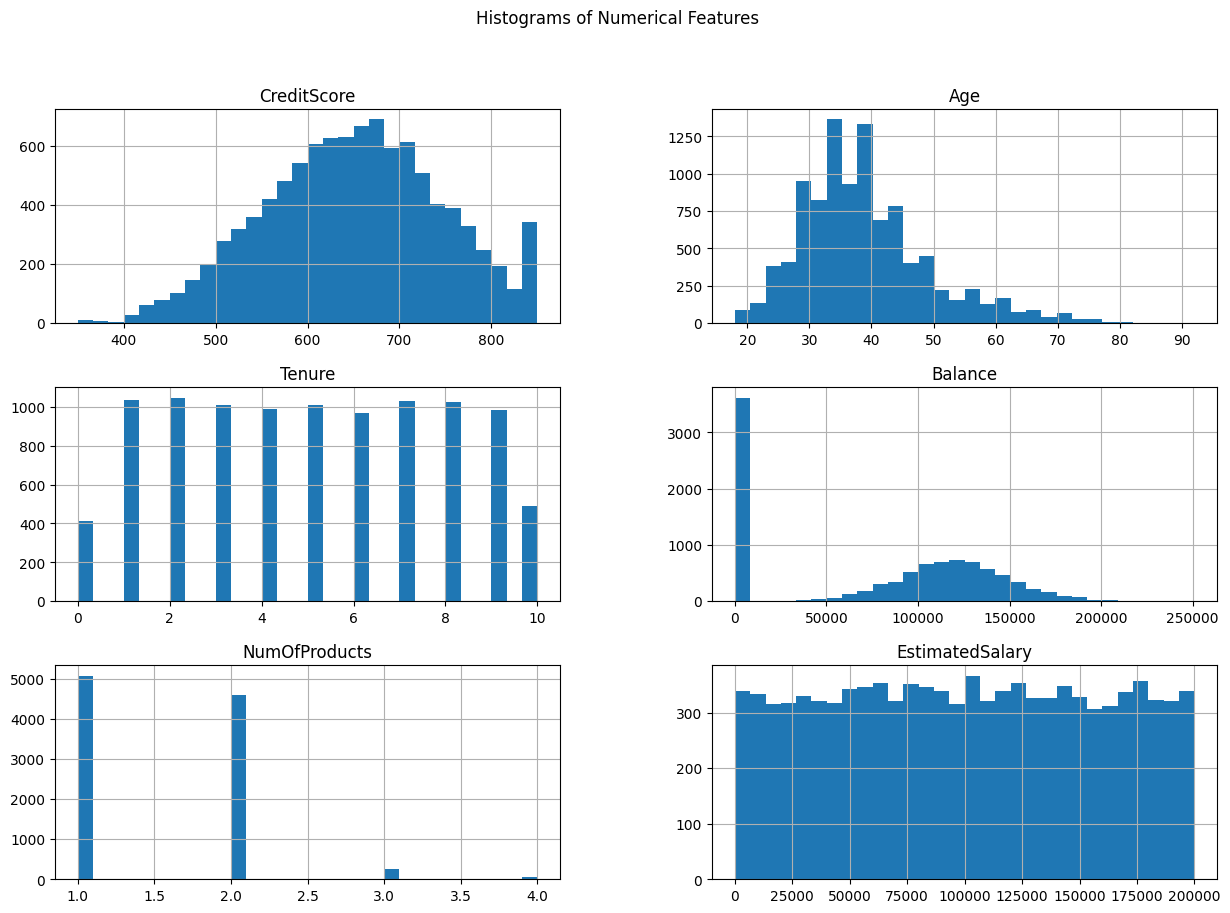

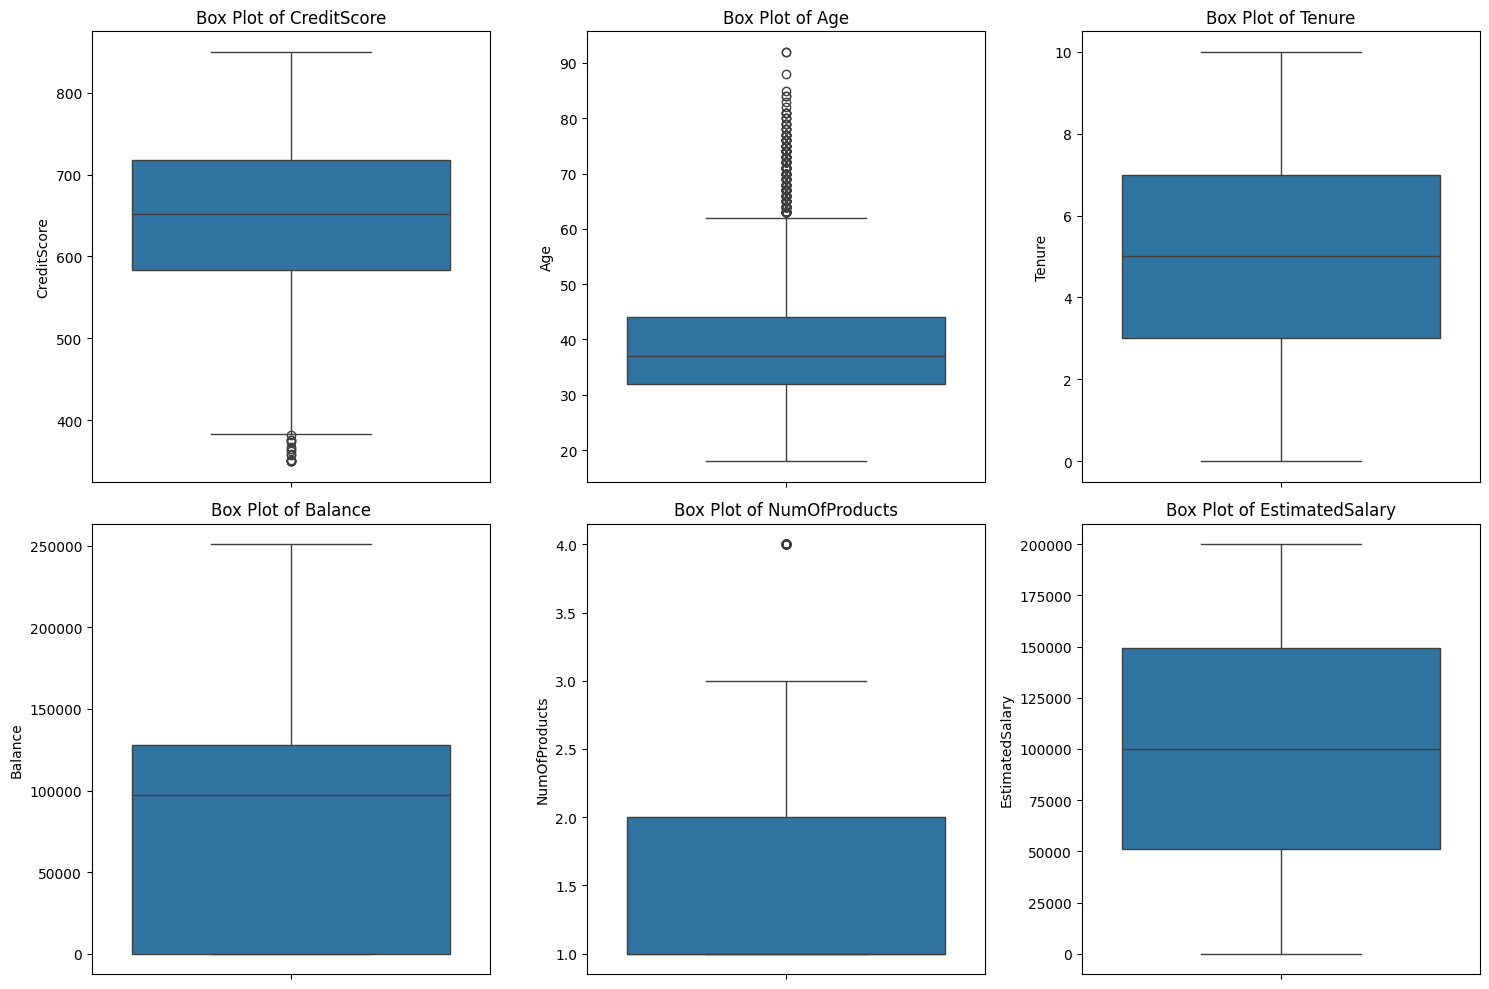

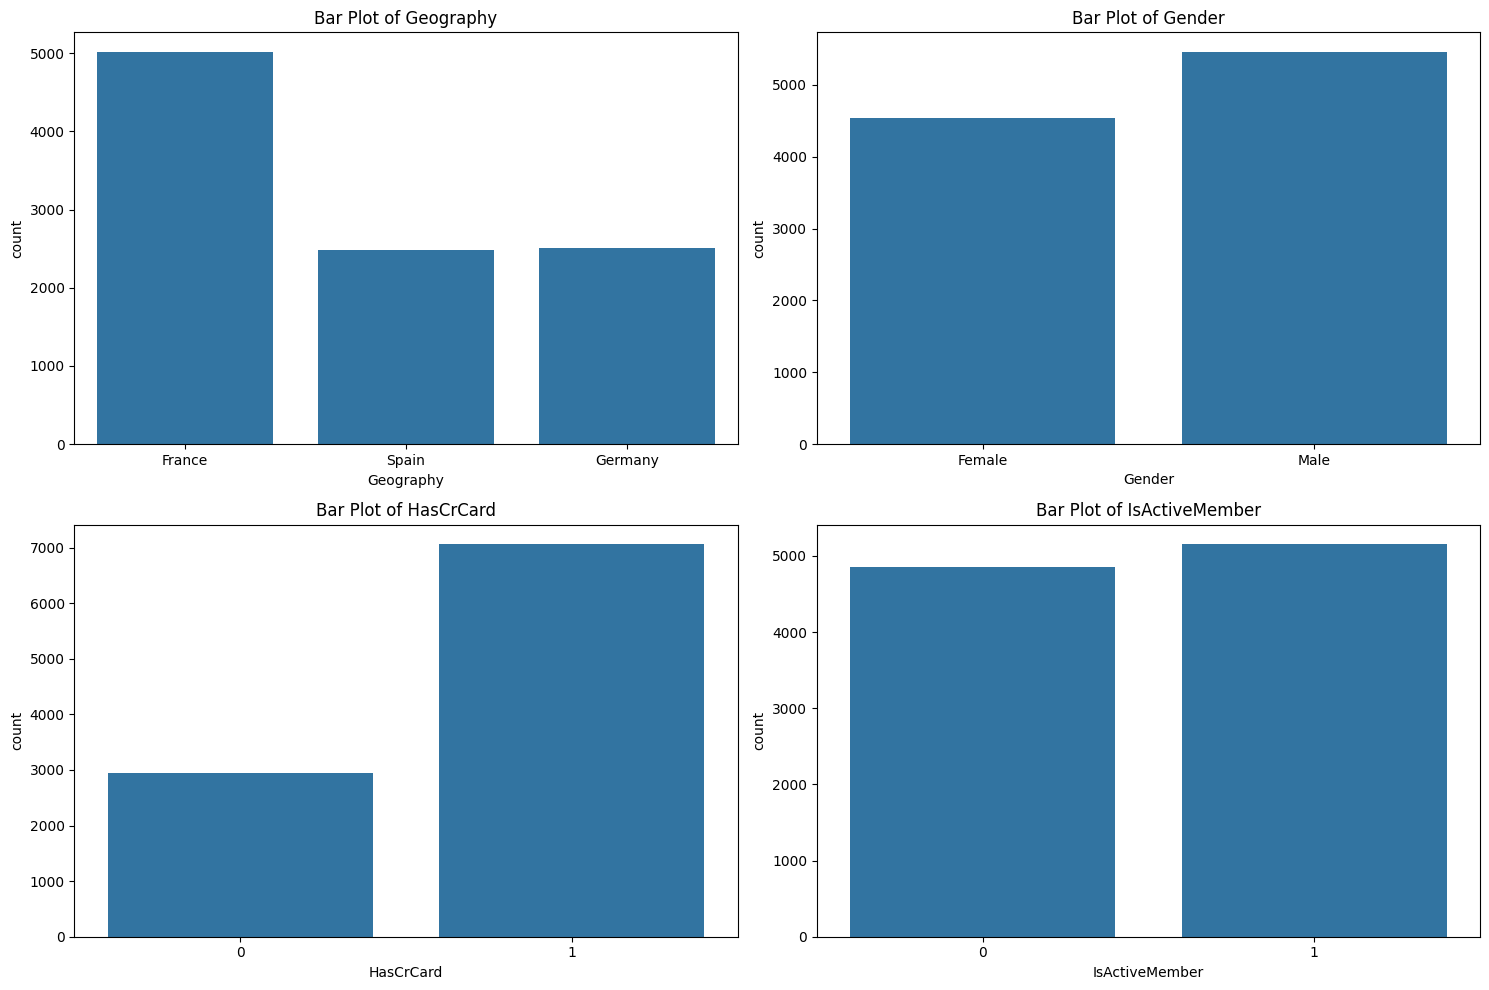

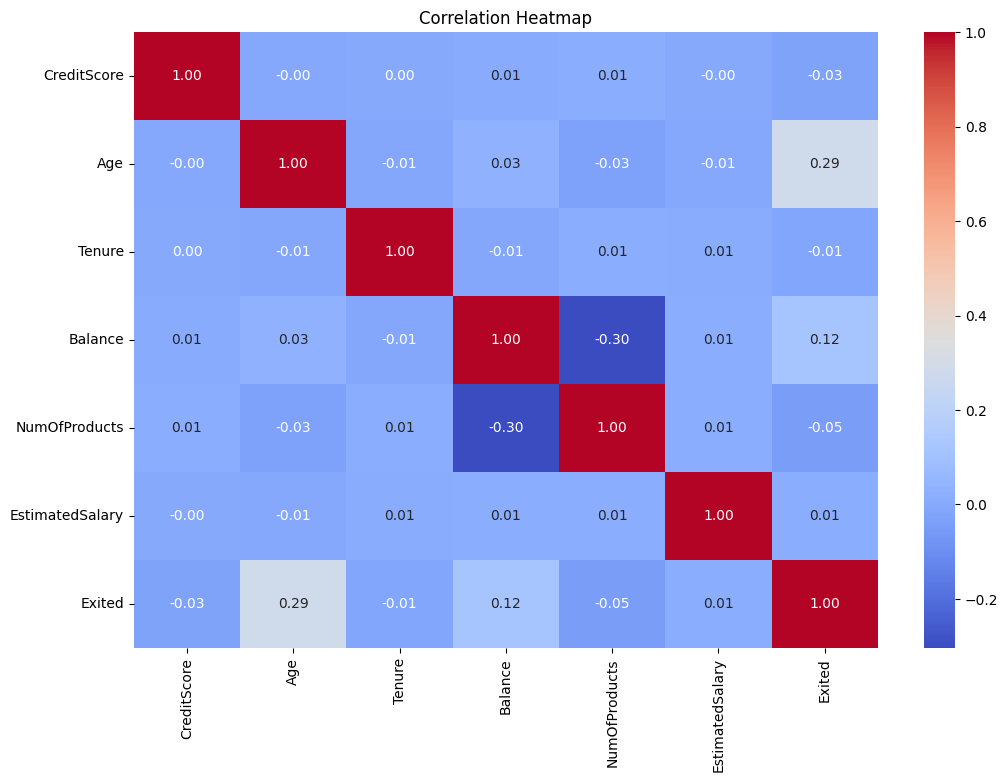

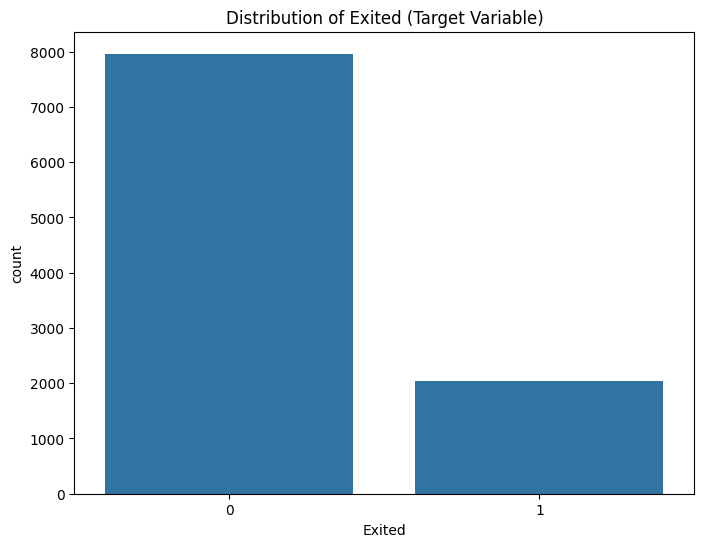

In [ ]:

# Histograms for numerical features
numerical_features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
df[numerical_features].hist(bins=30, figsize=(15, 10))
plt.suptitle('Histograms of Numerical Features')
plt.show()

# Box plots for numerical features
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(y=df[feature])
    plt.title(f'Box Plot of {feature}')
plt.tight_layout()
plt.show()

# Bar plots for categorical features
categorical_features = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember']
plt.figure(figsize=(15, 10))
for i, feature in enumerate(categorical_features, 1):
    plt.subplot(2, 2, i)
    sns.countplot(x=df[feature])
    plt.title(f'Bar Plot of {feature}')
plt.tight_layout()
plt.show()

# Correlation heatmap
plt.figure(figsize=(12, 8))
corr = df[numerical_features + ['Exited']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

# Target distribution (Exited)
plt.figure(figsize=(8, 6))
sns.countplot(x=df['Exited'])
plt.title('Distribution of Exited (Target Variable)')
plt.show()


**Feature Engineering**

In [ ]:



X = df.drop(['RowNumber', 'CustomerId', 'Surname', 'Exited'], axis=1)
y = df['Exited']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

categorical_features = ['Geography', 'Gender']
numerical_features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']

# Create a column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)


**Oversampling with SMOTE**

In [ ]:


smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)


**Model Training and Evaluation**

In [ ]:


models = {
    "KNN": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "SVM": SVC(probability=True, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42)
}

results = {}
for name, model in models.items():
    model.fit(X_train_res, y_train_res)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # For ROC-AUC
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    results[name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "ROC-AUC": roc_auc
    }
    print(f"\nClassification Report for {name}:")
    print(classification_report(y_test, y_pred))



Classification Report for KNN:
              precision    recall  f1-score   support

           0       0.90      0.77      0.83      1607
           1       0.42      0.67      0.51       393

    accuracy                           0.75      2000
   macro avg       0.66      0.72      0.67      2000
weighted avg       0.81      0.75      0.77      2000


Classification Report for Naive Bayes:
              precision    recall  f1-score   support

           0       0.90      0.74      0.81      1607
           1       0.39      0.66      0.49       393

    accuracy                           0.73      2000
   macro avg       0.64      0.70      0.65      2000
weighted avg       0.80      0.73      0.75      2000


Classification Report for SVM:
              precision    recall  f1-score   support

           0       0.92      0.80      0.86      1607
           1       0.47      0.72      0.57       393

    accuracy                           0.79      2000
   macro avg       0.70 

**Compare Algorithms**

In [ ]:
results_df = pd.DataFrame(results).T
print("\nModel Comparison:")
print(results_df)



Model Comparison:
               Accuracy  Precision    Recall  F1-Score   ROC-AUC
KNN              0.7500   0.415482  0.669211  0.512671  0.776895
Naive Bayes      0.7280   0.387816  0.664122  0.489681  0.795567
SVM              0.7875   0.473244  0.720102  0.571140  0.842559
Decision Tree    0.7720   0.436364  0.549618  0.486486  0.688001


**Save the Best Model**

In [ ]:
best_model = models["Decision Tree"]
joblib.dump(best_model, 'customer_churn_model.pkl')

['customer_churn_model.pkl']